Bu kod hücresinde, modelimizi oluşturmak ve değerlendirmek için gerekli olan kütüphaneleri içe aktarıyoruz. Kütüphaneler arasında makine öğrenimi metrikleri için sklearn, derin öğrenme için tensorflow.keras, veri işleme için numpy, pandas, görselleştirme için matplotlib ve seaborn yer almaktadır.

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

Bu kodda, balık veri setimizin bulunduğu dizini tanımlıyoruz ve içindeki balık türlerinin sayısını ve adlarını alıyoruz. Bu aşama, modelimizin öğrenmesi gereken sınıfları belirlemek için önemlidir.Bu hücrede, veri setindeki resimlerin dosya yollarını ve etiketlerini topluyoruz. os.walk() kullanarak, veri dizinini tarıyoruz ve her resmin etiketini (label) ve dosya yolunu (path) elde ediyoruz. Sonrasında bu verileri bir DataFrame’e dönüştürüyoruz.





In [3]:
# Kaggle veri seti dizini
data_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Kategorileri alalım (balık türleri)
categories = [ctg for ctg in os.listdir(data_dir) if '.' not in ctg]
print(f"{len(categories)} çeşit tür var:")
categories


labels = []
paths = []
for dir_name, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name.split():
            labels.append(os.path.split(dir_name)[-1])
            paths.append(os.path.join(dir_name, filename))


df = pd.DataFrame({'path': paths, 'label': labels})
print(df.info())

9 çeşit tür var:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None


Bu bölümde, veri setindeki her balık türünün dağılımını sayarak gösteriyoruz. Görselleştirme, veri dengesizliğini anlamak için önemlidir. Eğer bazı sınıflar çok fazla, bazıları ise çok azsa, bu durum modelin öğrenme sürecini olumsuz etkileyebilir (dengesiz veri). Çizilen grafik ile bu dengesizliği gözlemleyebiliriz.

In [4]:
# Veri setinin sınıf dağılımı
counts = df['label'].value_counts()
print(df['label'].value_counts())

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


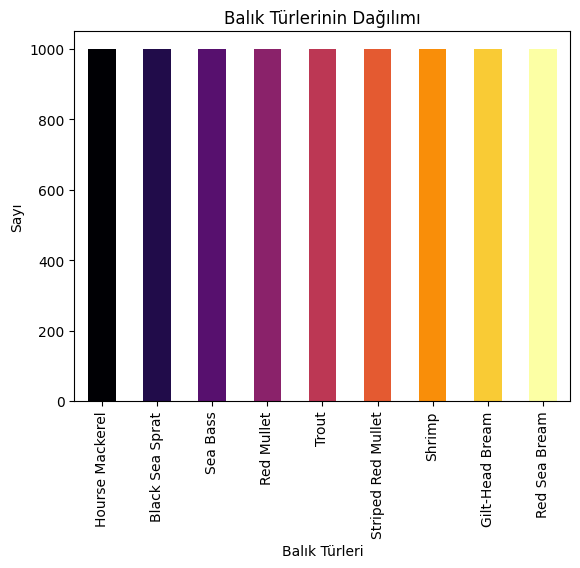

In [25]:
# Veri dengesizliği analizini görselleştirme
colors = plt.cm.inferno(np.linspace(0, 1, len(counts)))  # Renkleri tanımlama (örnek olarak rastgele renkler kullanıyoruz)
counts.plot.bar(color=colors)
plt.title('Balık Türlerinin Dağılımı')
plt.xlabel('Balık Türleri')
plt.ylabel('Sayı')
plt.show()


Bu kod parçası, görüntüleri okuyup boyutlandırıyor (225x225) ve normalize ediyor. Normalizasyon, görüntülerin pixel değerlerini [0, 1] aralığına çekmek için önemlidir; bu, modelin daha hızlı ve etkili bir şekilde öğrenmesini sağlar.

In [6]:
main_directory = data_dir
images, labels = [], []

for directory in tqdm(os.listdir(main_directory)):
    next_directory = os.path.join(main_directory, directory)
    if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
    for images_directory in os.listdir(next_directory):
        if "GT" not in images_directory:
            final_directory = os.path.join(next_directory, images_directory)
            for image in os.listdir(final_directory):
                img_path = os.path.join(final_directory, image)
                with Image.open(img_path) as img:
                    img = img.resize((225, 225))  # Boyutlandırma
                    img_array = np.asarray(img).astype('float32') / 255  # Normalize etme
                    images.append(img_array)
                    labels.append(images_directory)


100%|██████████| 12/12 [03:04<00:00, 15.36s/it]


Veri setimizi eğitim, doğrulama ve test setlerine bölüyoruz. İlk olarak, toplam verilerin %20'sini test verisi olarak ayırıyoruz. Daha sonra, geri kalan veriyi doğrulama ve test setlerine %50 oranında bölüyoruz. Bu işlem, modelin genelleme yeteneğini değerlendirmek için gereklidir.



In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test, shuffle=True)

Görüntü veri artırma, modelin daha fazla çeşitlilikte veri ile eğitilmesini sağlamak için kullanılır. Bu aşamada, döndürme, kaydırma, yatay çevirme ve parlaklık ayarlamaları gibi farklı teknikler uygulanır. Bu, modelin overfitting riskini azaltabilir.

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]  # Parlaklık değişimi
)
datagen.fit(X_train)

Veri setlerini numpy dizilerine dönüştürüyoruz. Bu dönüşüm, TensorFlow ve Keras ile daha kolay çalışmamızı sağlar. Ayrıca, verilerin boyutlarını kontrol ederek verilerin beklenen formatta olduğunu doğruluyoruz.

In [9]:
X_train = np.array([x for x in X_train])
y_train = np.array([y for y in y_train])
X_val = np.array([x for x in X_val])
y_val = np.array([y for y in y_val])
X_test = np.array([x for x in X_test])
y_test = np.array([y for y in y_test])

In [10]:
print(type(X_train))
print(X_train[0].shape)
print(X_val[0].shape)
print(X_test[0].shape)
len(X_train)

<class 'numpy.ndarray'>
(225, 225, 3)
(225, 225, 3)
(225, 225, 3)


7200

Model eğitimi için GPU kullanılıp kullanılmadığını kontrol ediyoruz. GPU kullanımı, modelin eğitim süresini önemli ölçüde azaltabilir. Eğer bir GPU varsa, bellek kullanımını dinamik hale getiriyoruz.



In [11]:
# TensorFlow'un GPU'yu algılayıp algılamadığını kontrol etme
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU kullanılıyor: {gpus[0]}")
else:
    print("GPU algılanamadı. Lütfen ayarları kontrol edin.")
    
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        # GPU'nun bellek kullanımını dinamik hale getiriyoruz
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU belleği dinamik olarak kullanılacak.")
    except RuntimeError as e:
        print(e)

GPU kullanılıyor: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU belleği dinamik olarak kullanılacak.


Sınıf etiketlerini one-hot encoding ile dönüştürüyoruz. Bu işlem, modelin çıktısının daha iyi anlaşılmasını ve işlenmesini sağlar. Dönüşüm sonrası verilerin şekillerini kontrol ederek doğru dönüşüm yapıldığını doğruluyoruz.

In [12]:
# Hedef verilerini one-hot encode etme
encoder = OneHotEncoder(sparse_output=False)

# Dönüştürmeden önce etiketlerin bir kısmını göster (ilk 5 etiket)
print("İlk 5 y_train etiketi:", y_train[:5])

# y_train, y_val ve y_test verilerini one-hot encode ediyoruz
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val = encoder.transform(np.array(y_val).reshape(-1, 1))
y_test = encoder.transform(np.array(y_test).reshape(-1, 1))

# Dönüşüm sonrası şekilleri kontrol et
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# İlk 5 y_train verisinin one-hot encoded hali
print("İlk 5 y_train one-hot encoded:", y_train[:5])

İlk 5 y_train etiketi: ['Hourse Mackerel' 'Gilt-Head Bream' 'Red Sea Bream' 'Trout' 'Red Mullet']
y_train shape: (7200, 9)
y_val shape: (900, 9)
y_test shape: (900, 9)
İlk 5 y_train one-hot encoded: [[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Modelin yapısını oluşturuyoruz. Sequential modeli ile katmanlar ekleyerek derin öğrenme modelimizi tanımlıyoruz. Her katman, LeakyReLU aktivasyon fonksiyonuyla birlikte Dropout katmanları içeriyor. Bu yapı, modelin daha karmaşık ilişkileri öğrenmesini sağlar ve overfitting riskini azaltır. Modelin özetini alarak katmanların detaylarını görebiliyoruz.

In [19]:
# Modeli oluşturma
model = Sequential([
    tf.keras.layers.Input(shape=(225, 225, 3)),
    Flatten(),
    
    Dense(512),
    LeakyReLU(alpha=0.01),  # LeakyReLU ile değiştirildi
    Dropout(0.3),
    
    Dense(256),
    LeakyReLU(alpha=0.01),  # LeakyReLU ile değiştirildi
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(alpha=0.01),  # LeakyReLU ile değiştirildi
    Dropout(0.1),
    
    Dense(64),
    LeakyReLU(alpha=0.01),  # LeakyReLU ile değiştirildi
    Dropout(0.05),
    
    Dense(9, activation='softmax')  # Çıkış katmanı
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 151875)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │    77,760,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,933,577 (297.29 MB)

 Trainable params: 77,933,577 (297.29 MB)

 Non-trainable params: 0 (0.00 B)

Modelimizi derlemek için Adam optimizasyon algoritmasını kullanıyoruz. categorical_crossentropy kayıp fonksiyonu, çok sınıflı sınıflandırma problemlerinde yaygın olarak kullanılır. Bu aşama, modelin öğrenme sürecini başlatmak için gereklidir.

Modelimizi eğitim verileri üzerinde eğitiyoruz. EarlyStopping callback'i, doğrulama kaybı belirli bir süre içinde iyileşmezse eğitim sürecini durdurmak için kullanılır. Bu, overfitting'i önlemek için önemlidir. Eğitim sonuçlarını results değişkenine kaydediyoruz.

In [20]:
# Adam optimizörü ile model derleme
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001  # Öğrenme oranı (gerektiği gibi ayarlayabilirsin)
)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
results = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.1455 - loss: 2.7748 - val_accuracy: 0.3167 - val_loss: 2.0098
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.2448 - loss: 2.0253 - val_accuracy: 0.4144 - val_loss: 1.7927
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3252 - loss: 1.8376 - val_accuracy: 0.5056 - val_loss: 1.5400
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4098 - loss: 1.6698 - val_accuracy: 0.5311 - val_loss: 1.3768
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4497 - loss: 1.5131 - val_accuracy: 0.6244 - val_loss: 1.2067
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4776 - loss: 1.4321 - val_accuracy: 0.6400 - val_loss: 1.1480
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5224 - loss: 1.3291 - val_accuracy: 0.6444 - val_loss: 1.0862
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5432 - loss: 1.2781 

Eğitim ve doğrulama doğruluğunu zamana (epoch) göre gösteren bir grafik çiziyoruz. Bu grafik, modelin zamanla ne kadar iyi öğrendiğini gösterir. Eğer eğitim doğruluğu artarken doğrulama doğruluğu sabit kalıyorsa veya düşüyorsa, bu durum overfitting belirtisi olabilir.

Eğitim ve doğrulama doğruluğunu zamana (epoch) göre gösteren bir grafik çiziyoruz. Bu grafik, modelin zamanla ne kadar iyi öğrendiğini gösterir. Eğer eğitim doğruluğu artarken doğrulama doğruluğu sabit kalıyorsa veya düşüyorsa, bu durum overfitting belirtisi olabilir.

Modelin test verileri üzerindeki performansını değerlendiriyoruz. classification_report fonksiyonu, modelin precision, recall ve F1-score gibi metriklerini döndürür. confusion_matrix, doğru ve yanlış tahminleri gösteren bir ısı haritası ile görselleştiriliyor. Bu, modelin hangi sınıflarda hatalar yaptığını anlamamıza yardımcı olur.



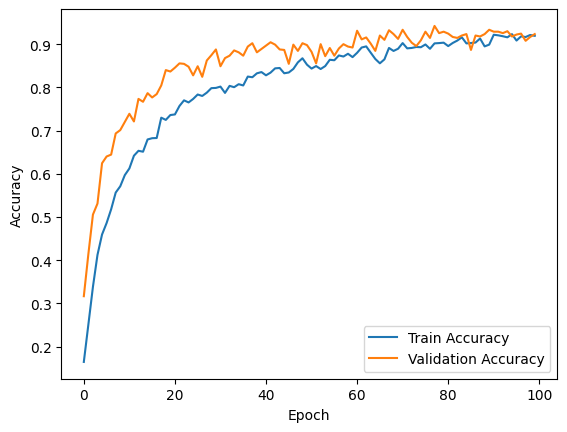

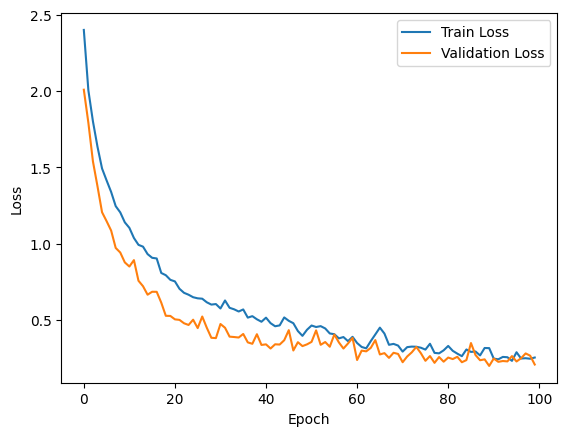

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       100
           1       0.94      0.94      0.94       100
           2       0.95      0.97      0.96       100
           3       0.97      0.98      0.98       100
           4       1.00      0.88      0.94       100
           5       0.92      0.86      0.89       100
           6       0.95      0.95      0.95       100
           7       0.90      0.97      0.93       100
           8       0.96      0.98      0.97       100

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



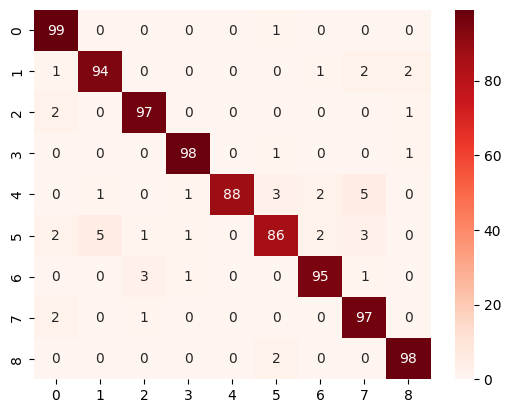

In [21]:
# Eğitim ve doğrulama doğruluk grafiği
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kayıp grafiği
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Modelin doğrulama setindeki performansı
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


print(classification_report(y_true_labels, y_pred_labels))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d', cmap='Reds')
plt.show()

ROC eğrileri, modelin sınıflandırma performansını gösterir. AUC (Area Under Curve), modelin genel doğruluğunu ölçen bir metriktir; 1.0’a yakın değerler daha iyi performansı gösterir. Bu eğriler, modelin farklı eşik değerlerinde nasıl davrandığını anlamamıza yardımcı olur.

**ROC**: ROC eğrisi, modelin sınıflandırma eşiği değiştiğinde, doğru pozitif oran (True Positive Rate - TPR) ile yanlış pozitif oran (False Positive Rate - FPR) arasındaki ilişkiyi gösteren bir grafiktir.

Doğru Pozitif Oranı (TPR): Gerçek pozitifler (modelin doğru tahmin ettiği olumlu örnekler) sayısının, toplam gerçek pozitif sayısına (gerçek olumlu örnekler) oranıdır.

Yanlış Pozitif Oranı (FPR): Gerçek negatifler (modelin doğru tahmin ettiği olumsuz örnekler) sayısının, toplam gerçek negatif sayısına (gerçek olumsuz örnekler) oranıdır.


**AUC**, ROC eğrisinin altındaki alanı ifade eder ve modelin genel performansını özetleyen bir metriktir. AUC değeri 0 ile 1 arasında bir değer alır.

AUC = 1: Model mükemmel bir şekilde ayrım yapabiliyor demektir.

AUC = 0.5: Model, rastgele tahmin yapıyor demektir (yani model hiçbir ayrım yapamıyor).

AUC < 0.5: Model, gerçekleri tersine tahmin ediyor demektir.



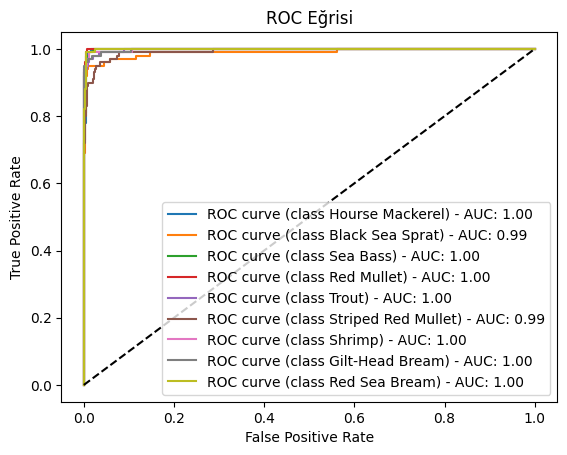

In [22]:
    # ROC ve AUC Eğrileri
    y_test_bin = label_binarize(y_true_labels, classes=range(len(categories)))
    y_pred_bin = label_binarize(y_pred_labels, classes=range(len(categories)))

    for i in range(len(categories)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {categories[i]}) - AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.show()


Confusion matrix'in normalize edilmiş hali ile her sınıfın doğruluğunu gösteriyoruz. Bu, her sınıfın ne kadar iyi sınıflandırıldığını yüzdelik olarak ifade eder. Eğer belirli sınıfların yüzdeleri düşükse, bu durum modelin o sınıflarda zayıf olduğunu gösterir.

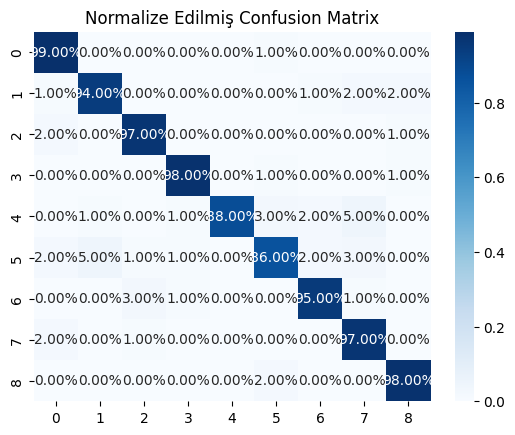

In [23]:
# Normalize Edilmiş Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Normalize Edilmiş Confusion Matrix')
plt.show()

Rastgele olarak seçilen beş test görüntüsü üzerinde modelin tahminlerini yapıyoruz. Her görüntüyü görselleştiriyor ve tahmin edilen sınıfı başlık olarak gösteriyoruz. Bu, modelin gerçek veriler üzerindeki performansını görsel olarak değerlendirmemizi sağlar.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


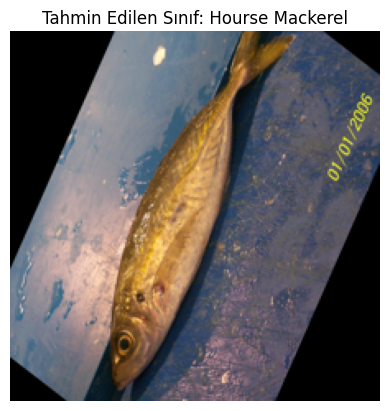

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


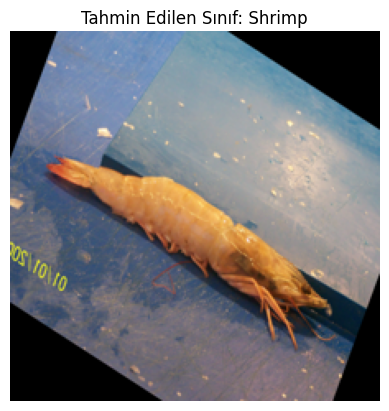

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


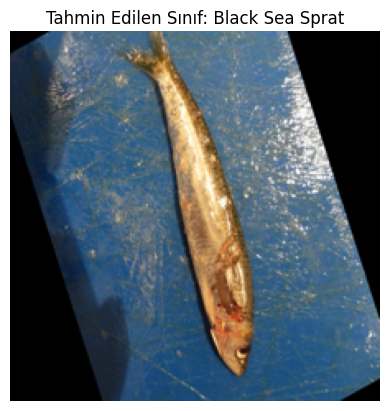

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


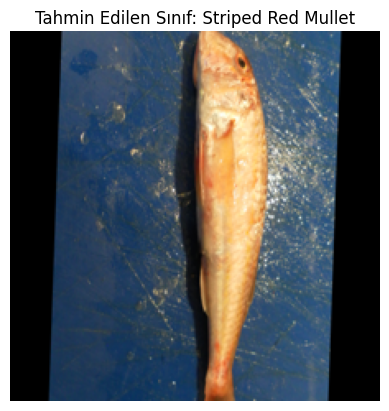

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


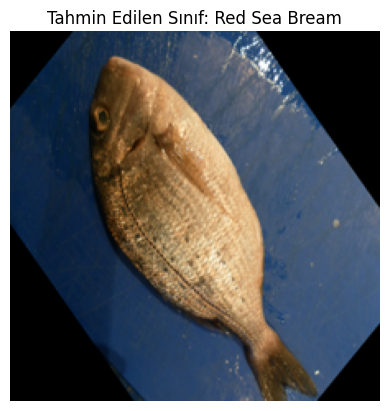

In [24]:
# Rastgele 5 test görüntüsü için tahmin yapma
sample_size = 5
selected_indices = random.sample(range(len(X_test)), sample_size)

for index in selected_indices:
    try:
        test_img_array = X_test[index]  # Seçilen görselin verisi
        test_img = test_img_array * 255  # Görseli orijinal boyutuna döndürmek için ölçekleme
        test_img = Image.fromarray(test_img.astype(np.uint8))  # NumPy dizisinden resme çevir

        # Model ile tahmin yapma
        test_img_array = np.expand_dims(test_img_array, axis=0)  # Modelin beklediği girdi boyutuna döndür
        predictions = model.predict(test_img_array)
        predicted_class_index = np.argmax(predictions)

        one_hot_predicted_class = np.zeros((1, encoder.categories_[0].size))
        one_hot_predicted_class[0][predicted_class_index] = 1

        predicted_class = encoder.inverse_transform(one_hot_predicted_class)

        # Tahmin edilen sınıfı görselleştirme
        plt.imshow(test_img)  
        plt.title(f'Tahmin Edilen Sınıf: {predicted_class[0][0]}')
        plt.axis('off') 
        plt.show()
        
    except Exception as e:
        print("Hata oluştu:", e)

# Modeli kaydetme ve yükleme
model.save('fish_model.h5')